In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [3]:
frames = [pd.read_csv('../data/transactions_1.csv', index_col=0), pd.read_csv('../data/transactions_2.csv', index_col=0)]
# frames = [pd.read_csv('../data/transactions_1.csv', index_col=0)]
df = pd.concat(frames)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date')

,customer_id,product_id,date
657826,8752181,G5HEPH9A2T,2017-01-01 08:32:26.307000+00:00
658033,8752181,RZ1BJ9ZV9C,2017-01-01 08:38:15.207000+00:00
755034,7269786,G5HEPH9A2T,2017-01-01 11:29:18.527000+00:00
755319,7269786,FA7OOL7Z3T,2017-01-01 11:59:30.613000+00:00
659733,5255027,FA7OOL7Z3T,2017-01-01 15:22:46.793000+00:00
...,...,...,...
294947,1971440,GJROWT9RPV,2020-03-16 23:29:31.810000+00:00
104192,8350659,G5HEPH9A2T,2020-03-16 23:54:22.647000+00:00
104658,8350659,XZ6UVEYK40,2020-03-16 23:58:40.210000+00:00
103766,8350659,GJROWT9RPV,2020-03-17 00:07:18.663000+00:00


# Questions
## Build a model to predict the total number of transactions for the next three months per customer anywhere in 2019. For example, given all data up to the end of January 2019, predict the size of the transactions between Feb 1st and April 30th for each customer. Then, measure the performance of your model with appropriate metrics and visuals.

In [4]:
selected_month = 1
prediction_start_date = f'2019-{selected_month}-01'
prediction_end_date = f'2019-{selected_month+3}-01'

In [5]:
transactions_per_month_df = df.groupby(['customer_id', pd.Grouper(freq='M', key='date', closed='left')])['customer_id'].count().unstack(fill_value=0)
transactions_per_month_df

date,2017-01-31 00:00:00+00:00,2017-02-28 00:00:00+00:00,2017-03-31 00:00:00+00:00,2017-04-30 00:00:00+00:00,2017-05-31 00:00:00+00:00,2017-06-30 00:00:00+00:00,2017-07-31 00:00:00+00:00,2017-08-31 00:00:00+00:00,2017-09-30 00:00:00+00:00,2017-10-31 00:00:00+00:00,...,2019-06-30 00:00:00+00:00,2019-07-31 00:00:00+00:00,2019-08-31 00:00:00+00:00,2019-09-30 00:00:00+00:00,2019-10-31 00:00:00+00:00,2019-11-30 00:00:00+00:00,2019-12-31 00:00:00+00:00,2020-01-31 00:00:00+00:00,2020-02-29 00:00:00+00:00,2020-03-31 00:00:00+00:00
customer_id,,,,,,,,,,,,,,,,,,,,,
1000178,0,0,24,0,0,0,0,47,29,0,...,0,0,0,0,0,0,0,0,0,0
1000692,0,0,6,0,0,0,0,0,0,0,...,3,2,8,5,19,6,24,1,8,5
1000821,0,0,0,0,0,0,0,0,0,0,...,0,3,14,5,1,17,7,13,4,0
1004714,0,3,0,0,3,1,2,0,0,4,...,0,5,5,0,0,0,0,0,1,0
1005470,0,0,0,0,0,1,0,2,0,3,...,0,0,0,3,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974841,0,0,0,0,0,8,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9976006,0,26,14,9,0,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9978245,3,37,32,14,5,39,8,79,48,8,...,31,1,1,0,23,2,1,0,0,0


In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

In [64]:
X = transactions_per_month_df.loc[:, transactions_per_month_df.columns.to_series().between('2017-01-01', prediction_start_date)].values
y = transactions_per_month_df.loc[:, transactions_per_month_df.columns.to_series().between(prediction_start_date, prediction_end_date)].sum(axis=1).values

In [65]:
X.shape, y.shape

((2002, 24), (2002,))

In [66]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X = x_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.reshape(-1, 1))[:, 0]

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [78]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [74]:
X_train.shape

(1601, 1, 24)

In [82]:
model = Sequential()
model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 24, 16)            1152      
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=0)

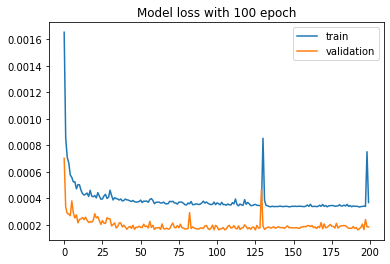

In [84]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss with 100 epoch')
plt.legend()
plt.show()

In [85]:
trainPredict = model.predict(X_train)
model.reset_states()
testPredict = model.predict(X_test)
# invert predictions
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 46.89 RMSE
Test Score: 34.15 RMSE
